# IDS using an RNN

# 1 Data loading and first analysis

In [2]:
import kagglehub
chethuhn_network_intrusion_dataset_path = kagglehub.dataset_download('chethuhn/network-intrusion-dataset')

print('Data source import complete.')


/home/fede/py/DeepLearning/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Data source import complete.


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Dropout
import numpy as np
from sklearn.impute import SimpleImputer
import os
import tensorflow as tf



In [4]:
# Load the dataset from folder ../Dataset and merge all CSV files
pds = []
for dirname, _, filenames in os.walk(chethuhn_network_intrusion_dataset_path):
    for filename in filenames:
        pds.append(pd.read_csv(f'{dirname}/{filename}'))
data = pd.concat(
    pds
)
del pds

In [5]:
data.sample(5, random_state=42)

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
62114,53,324,2,2,94,230,47,47,47.000000,0.000000,...,32,0.00000,0.000000,0,0,0.0,0.00000,0,0,BENIGN
262199,53,23950,2,2,70,244,35,35,35.000000,0.000000,...,20,0.00000,0.000000,0,0,0.0,0.00000,0,0,BENIGN
78803,80,99951883,9,7,317,11595,317,0,35.222222,105.666667,...,32,999.00000,0.000000,999,999,99900000.0,0.00000,99900000,99900000,DoS Hulk
14676,80,115993390,16,14,347,1792,263,0,21.687500,64.367402,...,20,26410.45455,7849.804474,49834,23504,10100000.0,72118.93849,10200000,9999095,BENIGN
8055,50581,999413,2,0,12,0,6,6,6.000000,0.000000,...,20,0.00000,0.000000,0,0,0.0,0.00000,0,0,BENIGN


Class distribution

In [6]:
counts = data[" Label"].value_counts(dropna=False)
perc = data[" Label"].value_counts(normalize=True, dropna=False).mul(100).round(6)

summary = pd.DataFrame({
    "count": counts,
    "percent": perc
})

print(summary)

                              count    percent
 Label                                        
BENIGN                      2273097  80.300366
DoS Hulk                     231073   8.162981
PortScan                     158930   5.614427
DDoS                         128027   4.522735
DoS GoldenEye                 10293   0.363615
FTP-Patator                    7938   0.280421
SSH-Patator                    5897   0.208320
DoS slowloris                  5796   0.204752
DoS Slowhttptest               5499   0.194260
Bot                            1966   0.069452
Web Attack � Brute Force       1507   0.053237
Web Attack � XSS                652   0.023033
Infiltration                     36   0.001272
Web Attack � Sql Injection       21   0.000742
Heartbleed                       11   0.000389


In [7]:
data[" Label"] = data[" Label"].apply(lambda x: "Web Attack Clean" if "Web Attack" in str(x) else x)
data[" Label"].value_counts()

 Label
BENIGN              2273097
DoS Hulk             231073
PortScan             158930
DDoS                 128027
DoS GoldenEye         10293
FTP-Patator            7938
SSH-Patator            5897
DoS slowloris          5796
DoS Slowhttptest       5499
Web Attack Clean       2180
Bot                    1966
Infiltration             36
Heartbleed               11
Name: count, dtype: int64

In [8]:
data.shape

(2830743, 79)

# 2. Data Analysis and cleaning

## 2.1 Duplicates and infintite


In [9]:
duplicates = data.duplicated()
duplicate_count = duplicates.sum()

print(f"Number of duplicate rows: {duplicate_count}")
print("value counts:")
print(duplicates.groupby(data[" Label"]).sum())

Number of duplicate rows: 308381
value counts:
 Label
BENIGN              176613
Bot                     13
DDoS                    11
DoS GoldenEye            7
DoS Hulk             58224
DoS Slowhttptest       271
DoS slowloris          411
FTP-Patator           2005
Heartbleed               0
Infiltration             0
PortScan             68111
SSH-Patator           2678
Web Attack Clean        37
dtype: int64


Removing duplicates from a dataset is often considered safe and benefinical.

In [10]:
# REMOVE DUPLICATES
data = data.drop_duplicates(keep='first')
del duplicates
del duplicate_count
data.shape

(2522362, 79)

Now we search for column duplicates.

In [11]:
identical_columns = {}
columns = data.columns
list_control = columns.copy().tolist()

# Compare each pair of columns
for col1 in columns:
    for col2 in columns:
        if col1 != col2:
            if data[col1].equals(data[col2]):
                if (col1 not in identical_columns) and (col1 in list_control):
                    identical_columns[col1] = [col2]
                    list_control.remove(col2)
                elif (col1 in identical_columns) and (col1 in list_control):
                    identical_columns[col1].append(col2)
                    list_control.remove(col2)

if identical_columns:
    print("Identical columns found:")
    for key, value in identical_columns.items():
        print(f"'{key}' is identical to {value}")
else: print("No identical columns found.")

Identical columns found:
' Total Fwd Packets' is identical to ['Subflow Fwd Packets']
' Total Backward Packets' is identical to [' Subflow Bwd Packets']
'Fwd PSH Flags' is identical to [' SYN Flag Count']
' Bwd PSH Flags' is identical to [' Bwd URG Flags', 'Fwd Avg Bytes/Bulk', ' Fwd Avg Packets/Bulk', ' Fwd Avg Bulk Rate', ' Bwd Avg Bytes/Bulk', ' Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate']
' Fwd URG Flags' is identical to [' CWE Flag Count']
' Fwd Header Length' is identical to [' Fwd Header Length.1']


In [12]:
for key, value in identical_columns.items():
    data.drop(columns=value, inplace=True)


In [13]:
data.replace([np.inf, -np.inf], np.nan, inplace=True)

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,389,113095465,48,24,9668,10012,403,0,201.416667,203.548293,...,32,203985.500,5.758373e+05,1629110,379,13800000.0,4.277541e+06,16500000,6737603,BENIGN
1,389,113473706,68,40,11364,12718,403,0,167.117647,171.919413,...,32,178326.875,5.034269e+05,1424245,325,13800000.0,4.229413e+06,16500000,6945512,BENIGN
2,0,119945515,150,0,0,0,0,0,0.000000,0.000000,...,0,6909777.333,1.170000e+07,20400000,6,24400000.0,2.430000e+07,60100000,5702188,BENIGN
3,443,60261928,9,7,2330,4221,1093,0,258.888889,409.702161,...,20,0.000,0.000000e+00,0,0,0.0,0.000000e+00,0,0,BENIGN
4,53,269,2,2,102,322,51,51,51.000000,0.000000,...,32,0.000,0.000000e+00,0,0,0.0,0.000000e+00,0,0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
692698,53,32215,4,2,112,152,28,28,28.000000,0.000000,...,20,0.000,0.000000e+00,0,0,0.0,0.000000e+00,0,0,BENIGN
692699,53,324,2,2,84,362,42,42,42.000000,0.000000,...,20,0.000,0.000000e+00,0,0,0.0,0.000000e+00,0,0,BENIGN
692700,58030,82,2,1,31,6,31,0,15.500000,21.920310,...,32,0.000,0.000000e+00,0,0,0.0,0.000000e+00,0,0,BENIGN
692701,53,1048635,6,2,192,256,32,32,32.000000,0.000000,...,20,0.000,0.000000e+00,0,0,0.0,0.000000e+00,0,0,BENIGN


### 2.2 Missing values

In [14]:
# Attack counts
attack_counts = data[' Label'].value_counts().reset_index()
attack_counts.columns = ['Attack Type', 'Number of Occurrences']

# Duplicating the df and dropping rows with missing values
data_no_na = data.dropna()

# Counting the total number of occurrences of each attack after dropping
occurrences_nonull = data_no_na[' Label'].value_counts().reset_index()
occurrences_nonull.columns = ['Attack Type', 'Occurrences w/o Null Rows']

# Merging the DataFrames
attack_counts = attack_counts.merge(occurrences_nonull, on='Attack Type', how='left')

# Calculating the difference
attack_counts['Abs Difference'] = attack_counts['Number of Occurrences'] - attack_counts['Occurrences w/o Null Rows']
attack_counts['Difference %'] = ((attack_counts['Abs Difference'] * 100) / attack_counts['Number of Occurrences']).round(2)

# Visualization
attack_counts

,Attack Type,Number of Occurrences,Occurrences w/o Null Rows,Abs Difference,Difference %
0,BENIGN,2096484,2095057,1427,0.07
1,DoS Hulk,172849,172846,3,0.00
2,DDoS,128016,128014,2,0.00
3,PortScan,90819,90694,125,0.14
4,DoS GoldenEye,10286,10286,0,0.00
5,FTP-Patator,5933,5931,2,0.03
6,DoS slowloris,5385,5385,0,0.00
7,DoS Slowhttptest,5228,5228,0,0.00
8,SSH-Patator,3219,3219,0,0.00
9,Web Attack Clean,2143,2143,0,0.00


Because most of the missing values are `BENIGN`, we can cosndiering removing those rows beneficial for the model training.
Before deletating those rows we search if the nan values are concentraed in a single column.

In [15]:
del data_no_na

# Evaluating percentage of missing values per column
threshold = 10
missing_percentage = (data.isnull().sum() / len(data)) * 100

high_missing_cols = missing_percentage[missing_percentage > threshold]

if len(high_missing_cols) > 0:
    print(f'The following columns have over {threshold}% of missing values:')
    print(high_missing_cols)
else:
    print('There are no columns with missing values greater than the threshold')

There are no columns with missing values greater than the threshold


In [16]:
# Dropping missing values
data = data.dropna()
print(f'Dataset shape after row-wise removal: {data.shape}')

Dataset shape after row-wise removal: (2520798, 67)


### 2.3 Removing unique columns

In [17]:
only_unique_cols = []
for col in data.columns:
    if len(data[col].unique()) == 1:
        only_unique_cols.append(col)
        print(col)

print(f'\nThe number of columns with only one unique values is: {len(only_unique_cols)}')

 Bwd PSH Flags

The number of columns with only one unique values is: 1


In [18]:
data.drop(only_unique_cols, axis=1, inplace=True)
del only_unique_cols

In [19]:
data.shape

(2520798, 66)

### 2.4 Grouping attack types

We group similar attacks types

In [20]:
mapping = mapping = {
    "BENIGN": 0,
    # DoS/DDoS
    "DDoS": 1, "DoS Hulk": 1, "DoS GoldenEye": 1, "DoS slowloris": 1, "DoS Slowhttptest": 1,
    # Brute Force
    "FTP-Patator": 2, "SSH-Patator": 2,
    # Web Attacks
    "Web Attack Clean": 3,
    # Scanning
    "PortScan": 4,
    # Bot
    "Bot": 5,
    #Infiltration
    "Infiltration": 6,
    # Heartbleed 
    "Heartbleed": 7
}

data[' Label'] = data[' Label'].map(mapping)
data[' Label'].value_counts()

 Label
0    2095057
1     321759
4      90694
2       9150
3       2143
5       1948
6         36
7         11
Name: count, dtype: int64

Because of the low number of samples we remove `Infiltration` and `Heartbleed`.

In [21]:
data.drop(data[(data[' Label'] == 7) | (data[' Label'] == 6)].index, inplace=True)

In [22]:
data.shape

(2520537, 66)

### 2.5 Benign downsampling
Because of the high level of class imbalance we decided to remove a percentage of `Benign` Label

In [ ]:
def ordered_downsampling(df, target_label=0, keep_fraction=0.2, chunk_size=100):
    chunks = []
    for i in range(0, len(df), chunk_size):
        chunk = df.iloc[i:i + chunk_size]
        
        # If the chuunk contains any row with the target label, we keep it.
        if not (chunk[' Label'] == target_label).all():
            chunks.append(chunk)
        else: # Else we keep it with a certain probability
            if np.random.rand() < keep_fraction:
                chunks.append(chunk)
                
    return pd.concat(chunks).reset_index(drop=True)

data = ordered_downsampling(data, target_label=0, keep_fraction=0.2)

In [24]:
print("Class distribution:")
print(data[" Label"].value_counts())
print(f"\nShape of the dataset: {data.shape}")

Class distribution:
 Label
0    779401
1    321714
4     90682
2      9150
3      2142
5      1948
Name: count, dtype: int64

Shape of the dataset: (1205037, 66)


In [25]:
data.to_csv('processed_dataset.csv', index=False)

In [26]:
# Uncomment to load the processed dataset if you have already run the preprocessing steps
data = pd.read_csv('processed_dataset.csv')

### 2.6 Dataset split
For splitting the dataset we get the last 20 percentage of each class, because attacks in the same group are similar so the model try to memorise the attacks type instead of learning.
For Scaling data we use the Roubust scalaer because of the precence of outliner (like traffic when a Dos attack is performed)

In [27]:
from sklearn.preprocessing import RobustScaler

num_classes = data[" Label"].nunique() 
X = data.drop(columns=[" Label"])
y = data[" Label"] 

# Clean nan for safty
mask = ~y.isna()
X = X[mask]
y = y[mask]

def get_stratified_split(X, y, test_size=0.2):
    train_idxs = []
    test_idxs = []
    
    # for each class, take the first 80% (Train) and the last 20% (Test)
    for label in np.unique(y):
        # find indices of this class
        idxs = np.where(y == label)[0]
        split_point = int(len(idxs) * (1 - test_size))
        
        train_idxs.extend(idxs[:split_point])
        test_idxs.extend(idxs[split_point:])
    
    # Order the indices to maintain temporal sequence
    train_idxs.sort()
    test_idxs.sort()
    
    return X.iloc[train_idxs], X.iloc[test_idxs], y.iloc[train_idxs], y.iloc[test_idxs]

X_train_df, X_test_df, y_train_s, y_test_s = get_stratified_split(X, y)

print(f"Train samples: {len(X_train_df)}")
print(f"Test samples: {len(X_test_df)}")
print("Test Class Distribution:\n", y_test_s.value_counts())

scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_df)
X_test_scaled = scaler.transform(X_test_df)

time_steps = 10
batch_size = 64 

Train samples: 964027
Test samples: 241010
Test Class Distribution:
  Label
0    155881
1     64343
4     18137
2      1830
3       429
5       390
Name: count, dtype: int64


In [28]:
data[" Label"].unique()

array([0, 3, 1, 4, 5, 2])

### 2.7 Sliding window
Because a single log cannot identify some attacks type (Port scan), we decided to use a sliding windows approch and use the tensorflow utils for generating it.

In [29]:
# Train Generator
train_gen = tf.keras.utils.timeseries_dataset_from_array(
    data=X_train_scaled,
    targets=y_train_s.values[time_steps-1:], 
    sequence_length=time_steps,
    batch_size=batch_size,
    shuffle=True 
).prefetch(tf.data.AUTOTUNE)

# Test Generator
test_gen = tf.keras.utils.timeseries_dataset_from_array(
    data=X_test_scaled,
    targets=y_test_s.values[time_steps-1:],
    sequence_length=time_steps,
    batch_size=batch_size,
    shuffle=False
).prefetch(tf.data.AUTOTUNE)

2026-02-20 08:44:54.289259: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


## 3. Model
We used a 2 layer sequetial, with a BatchNormalization between the LSTM and Dense Layer.
Also in order to mitigate the class distribution we used class_weight, to give more importance in the loss function to low sampled Labels, an early stop wich monitor the validation loss and stop if doesen't imporve after a cetain number of epoches. Moreover we setted a low learning rate of 1e-4 and gradient clipping 

In [ ]:


from keras.layers import LSTM, BatchNormalization, Input
from sklearn.utils.class_weight import compute_class_weight

weights = compute_class_weight('balanced', classes=np.unique(y_train_s), y=y_train_s)
class_weight_dict = dict(enumerate(weights))
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model = Sequential()
model.add(Input(shape=(time_steps, X_train_scaled.shape[1])))
model.add(SimpleRNN(64, dropout=0.3))
model.add(BatchNormalization()) 
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4, clipnorm=1.0),
              loss='sparse_categorical_crossentropy',
              metrics=["accuracy"]
              )

model.summary()

model.fit(
    train_gen,
    epochs=50,
    validation_data=test_gen,
    class_weight=class_weight_dict,
    callbacks=[early_stop],
)

loss, accuracy = model.evaluate(test_gen)
print(f"Loss: {loss}, Accuracy: {accuracy}")


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 64)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,854 (42.40 KB)

 Trainable params: 10,726 (41.90 KB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/50
15063/15063 ━━━━━━━━━━━━━━━━━━━━ 104s 7ms/step - accuracy: 0.7985 - loss: 0.8053 - val_accuracy: 0.9231 - val_loss: 0.2247
Epoch 2/50
15063/15063 ━━━━━━━━━━━━━━━━━━━━ 122s 8ms/step - accuracy: 0.8866 - loss: 0.5191 - val_accuracy: 0.9228 - val_loss: 0.1988
Epoch 3/50
15063/15063 ━━━━━━━━━━━━━━━━━━━━ 121s 8ms/step - accuracy: 0.8985 - loss: 0.5074 - val_accuracy: 0.9329 - val_loss: 0.1862
Epoch 4/50
15063/15063 ━━━━━━━━━━━━━━━━━━━━ 122s 8ms/step - accuracy: 0.9062 - loss: 0.5093 - val_accuracy: 0.9397 - val_loss: 0.1970
Epoch 5/50
15063/15063 ━━━━━━━━━━━━━━━━━━━━ 123s 8ms/step - accuracy: 0.9099 - loss: 0.4917 - val_accuracy: 0.9382 - val_loss: 0.1981
Epoch 6/50
15063/15063 ━━━━━━━━━━━━━━━━━━━━ 122s 8ms/step - accuracy: 0.9090 - loss: 0.4945 - val_accuracy: 0.9373 - val_loss: 0.1947
Epoch 7/50
15063/15063 ━━━━━━━━━━━━━━━━━━━━ 122s 8ms/step - accuracy: 0.9080 - loss: 0.5110 - val_accuracy: 0.9431 - val_loss: 0.1672
Epoch 8/50
15063/15063 ━━━━━━━━━━━━━━━━━━━━ 123s 8ms/step - ac

In [38]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import numpy as np

# Make predictions on the test set
y_pred_probabilities = model.predict(test_gen)
y_pred = np.argmax(y_pred_probabilities, axis=1)
y_test_aligned = y_test_s.values[time_steps - 1:]
# Calculate Precision, Recall, and F1-Score
# 'weighted' is chosen to account for class imbalance when averaging metrics
precision = precision_score(y_test_aligned, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test_aligned, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test_aligned, y_pred, average='weighted', zero_division=0)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Optionally, display the confusion matrix for more detailed insight
print("\nConfusion Matrix:")
print(confusion_matrix(y_test_aligned, y_pred))
model.evaluate(test_gen)


3766/3766 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step
Precision: 0.9674
Recall: 0.9664
F1-Score: 0.9660

Confusion Matrix:
[[155049    196    133    274     17    212]
 [  6445  57709     14    171      1      3]
 [     6      0   1824      0      0      0]
 [    45      0      8    367      0      0]
 [    42    111      1     17  17950     16]
 [     3    387      0      0      0      0]]
3766/3766 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - accuracy: 0.9664 - loss: 0.1142


[0.11424428969621658, 0.9663819074630737]

In [39]:
#value counts for y_pred and y_test_aligned
print("y_test_aligned value counts:")
print(pd.Series(y_test_aligned).value_counts())
print("\ny_pred value counts:")
print(pd.Series(y_pred).value_counts())


y_test_aligned value counts:
0    155881
1     64343
4     18137
2      1830
3       420
5       390
Name: count, dtype: int64

y_pred value counts:
0    161590
1     58403
4     17968
2      1980
3       829
5       231
Name: count, dtype: int64


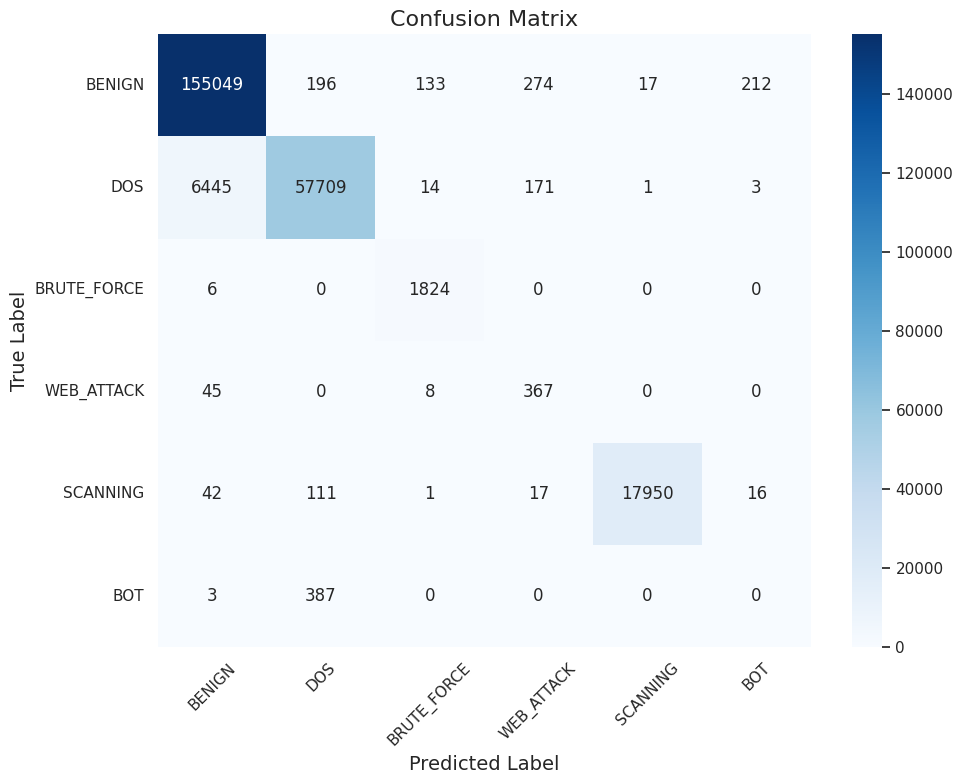

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

class_names = ['BENIGN', 'DOS', 'BRUTE_FORCE', 'WEB_ATTACK', 'SCANNING', 'BOT']

cm = confusion_matrix(y_test_aligned, y_pred)

plt.figure(figsize=(10, 8))
# cmap="Blues" crea un bell'effetto visivo accademico
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

plt.title('Confusion Matrix', fontsize=16)
plt.ylabel('True Label', fontsize=14)
plt.xlabel('Predicted Label', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()

# Salva l'immagine per usarla in LaTeX
plt.savefig('confusion_matrix.pdf', format='pdf')
plt.show()

In [41]:
# Training dataset: targets allineati (indice time_steps - 1)

model.save('rnn_model_best.keras')